In [37]:
import numpy as np
import pandas as pd
import sys
from matplotlib import pyplot as plt
import random
import math
import phate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import datetime
import json
import pickle

In [38]:
cytokines = pd.read_csv("data/allcytokinesmerged_20200730_ANON.csv")

In [39]:
#Goal: Collect N x D matrix for each patient (N=number of time points, D=number of features)


#Step 1: Get uniuqe list of ID's
temp = cytokines.iloc[:,0].unique()
unique = [x for x in temp if isinstance(x,str)]
uniqueID = np.array(unique)

#Step 2: Construct N X D pandas data frame for each patient
nmeas = cytokines.iloc[:,0].shape[0]
npat = uniqueID.shape[0]
nfeat = cytokines.iloc[0,:].shape[0]
print(nfeat)



metatensor = []
patensor = []
for i in range(npat):
    patmat = []
    metapat = []
    for j in range(nmeas):
        
        
        #Check if uniqueID matches when there is not a nan
        if isinstance(cytokines.iloc[j,0],str):
            if uniqueID[i] == cytokines.iloc[j,0]:
                patmat.append(cytokines.iloc[j,2:].values)
                metapat.append(cytokines.iloc[j,:2].values)
                
        else:       
            for k in range(j,-1,-1):
                if isinstance(cytokines.iloc[k,0],str) and uniqueID[i] != cytokines.iloc[k,0]:
                    break
                if isinstance(cytokines.iloc[k,0],str) and uniqueID[i] == cytokines.iloc[k,0]:
                    patmat.append(cytokines.iloc[j,2:].values)
                    metapat.append(cytokines.iloc[j,:2].values)
                    break
            
    patensor.append(patmat)
    metatensor.append(metapat)

patensor = [np.array(x).astype(float) for x in patensor]
metatensor = [np.array(x) for x in metatensor]

#Observation mask
mask = [~np.isnan(x).astype(bool) for x in patensor]
featuredim=114



116


Number of patients:  202
7.425742574257426
30.350794511966107


Text(0, 0.5, '# of measurements')

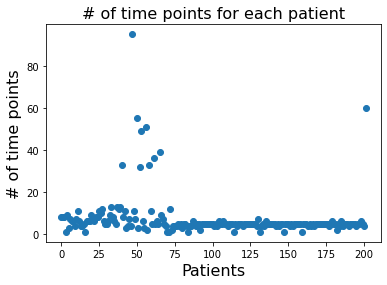

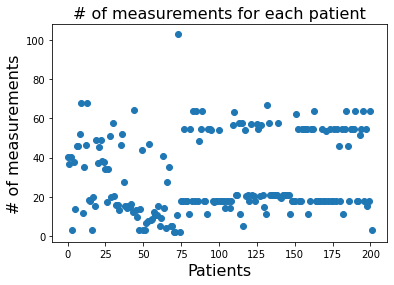

In [40]:
#store true dimensionality of each patient
truedims = [] 
for j in range(npat):
    dims = []
    ntime = patensor[j][:,0].shape[0]
    for i in range(ntime):
        dims.append(np.sum(~np.isnan(patensor[j][i,:])))
    truedims.append(dims)
truedims = [np.array(x) for x in truedims]
avdims = [x.mean(0) for x in truedims]



#Compute time vector for each patient (time between patients [days])
patimes =[]
for j in range(npat):

    ntime = metatensor[j][:,0].shape[0]
    days = []
    for i in range(ntime):
        x = pd.to_datetime(metatensor[j][i,1]) - pd.to_datetime(metatensor[j][0,1])
        days.append(x.total_seconds()/86400)
        
    patimes.append(days)

patimes = [np.array(x) for x in patimes]



#get number of time points for each patient
avtmpts = []
for j in range(npat):
    
    ntime = patensor[j][:,0].shape[0]
    avtmpts.append(ntime)




#Check Number of patients
print("Number of patients: ",len(patensor))


nbtpts = []
#Get average number of time points per patient
for i in range(len(patimes)):
    nbtpts.append(len(patimes[i]))
    
nbdim = []
for i in range(len(mask)):
    nbdim.append(mask[i].sum()/mask[i].shape[0])


print(np.mean(nbtpts))
print(np.mean(nbdim))
    
plt.figure()
plt.title("# of time points for each patient",fontsize=16)
plt.scatter(np.arange(len(nbtpts)),nbtpts)
plt.xlabel("Patients",fontsize=16)
plt.ylabel("# of time points",fontsize=16)

plt.figure()
plt.title("# of measurements for each patient",fontsize=16)
plt.scatter(np.arange(len(nbdim)),nbdim)
plt.xlabel("Patients",fontsize=16)
plt.ylabel("# of measurements",fontsize=16)

# Convert Nan's to 0's (as desired by GRU-ODE)

In [41]:

for j in range(len(patensor)):
    ntime = patensor[j][:,0].shape[0]
    for i in range(ntime):
        ndim = patensor[j][0,:].shape[0]
        for k in range(ndim):
            if np.isnan(patensor[j][i,k]):
                patensor[j][i,k] = 0 
                
                
#Discard patients with less than 3 time points
onetimept = []
for j in reversed(range(len(patensor))):
    #print(j)
    if patensor[j].shape[0] < 3:
        patimes.pop(j)
        mask.pop(j)
        patensor.pop(j)
        metatensor.pop(j)
        
print("Number of patients after discarding patients w/ < k time points",len(patensor))

npat = len(patensor)

Number of patients after discarding patients w/ < k time points 189


# Preliminary Statistics/Feature Engineering

(8, 114)
(114, 8)
(114, 114)
1774852948.6365457
92627284443.04677
                 ID                       Arm Name TreatmentStartDate  \
0    01-1-01ZL1 007  Group3a - Non-randomized IMRT          10/3/2011   
1    02-1-01ZL1 093       Group1 - Randomized IMRT           3/8/2011   
2    02-1-01ZL1 217     Group2 - Randomized Proton          6/12/2013   
3    02-1-01ZL1 053     Off Study - Non-Randomized          9/28/2010   
4    02-1-01ZL1 014  Group3a - Non-randomized IMRT         11/10/2009   
..              ...                            ...                ...   
220  02-1-01ZL1 264     Group2 - Randomized Proton           3/6/2014   
221  02-1-04ZL1-009     Off Study - Non-Randomized          3/10/2014   
222  02-1-01ZL1 272     Off Study - Non-Randomized          4/21/2014   
223  02-1-01ZL1 274       Group1 - Randomized IMRT          4/30/2014   
224  02-1-01ZL1 271     Off Study - Non-Randomized          4/22/2014   

    TreatmentEndDate Last_Contact_Date   cardioEvent  CAE

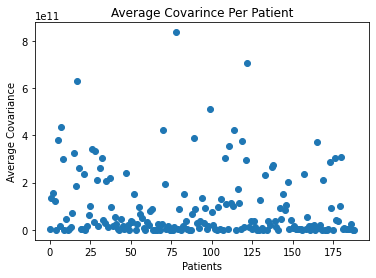

In [42]:
#Compute covariance for each patient (should be D X D feature matrix)

#Patient Level

print(patensor[0].shape)
print(patensor[0].T.shape)
covmat = np.cov(patensor[0].T)
print(covmat.shape)
print(np.mean(covmat))

avgcov = []
for i in range(len(patensor)):
    avgcov.append(np.mean(np.cov(patensor[i].T)))
    
plt.title("Average Covarince Per Patient")
plt.scatter(np.arange(len(patensor)),avgcov)
plt.xlabel("Patients")
plt.ylabel("Average Covariance")
totavg = np.mean(avgcov)
print(totavg)
#Entire dataset

# Logistic regression between cytokine and endpoints for feature selection

#Step 1: Load end point data
CAE_data = pd.read_csv("data/CAE_data_04092021_ANON.csv")
target = CAE_data['CAE2']


print(CAE_data)

print(CAE_data['ID'][10].replace(" ",""))
print(metatensor[0][0][0])
print(len(CAE_data))

print(len(patensor))
    

In [43]:
print("Time pts X Dimensionality for each patient",(patensor[0]).shape)

Time pts X Dimensionality for each patient (8, 114)


[7, 19, 20, 21, 25, 46, 54, 93]


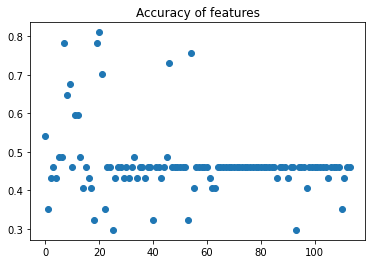

In [44]:
#Get unique indeces for patients with less than 3 data points
nfeat = 114
nunid = []
for i in range(len(metatensor)):
    nunid.append(metatensor[i][0][0])
    


"""
print(nunid[0])
print(CAE_data['ID'][0].replace(" ",""))
print(CAE_data['CAE2'][0])

for i in range(len(CAE_data)):
    for j in range(len(metatensor)):MM
        if CAE_data"""

#Gets vector of indices sorted according to original target data
indx = []
for i in range(len(CAE_data)):
    for j in range(len(metatensor)):
        if CAE_data['ID'][i].replace(" ","") == nunid[j]:
            indx.append(j)
            #indx.append(CAE_data['CAE2'][i])
            
 

#Create array X,Y data based on unique ID's
impfeat = []
scores = []    
ntime = 4
for k in range(nfeat):
    npatlog = len(indx)
    feature = k
    

    Y = np.zeros(npatlog)
    X = np.zeros((npatlog,ntime))

    for i in range(len(indx)):

        if patensor[indx[i]][:ntime,feature].shape[0] < ntime:
            continue
        
        X[i,:] = patensor[indx[i]][:ntime,feature]
        Y[i] = CAE_data['CAE2'][i]

    

    #Apply logistic regression
  
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2,random_state=42)
    clf = LogisticRegression(random_state=0,class_weight='balanced').fit(X,Y)
    pred = clf.predict(X_test)
    scores.append(clf.score(X_test,y_test))
    
    if clf.score(X_test,y_test) > 0.70 or clf.score(X_test,y_test) < 0.3:
        impfeat.append(k)


plt.figure()
plt.title("Accuracy of features")
plt.scatter(np.arange(nfeat),scores)
print(impfeat)

# Getting top features based on PCA

#  GRU-ODE  (dim-reduction)

In [11]:
# Store most important features from logistic regression

fintimes = []
finarray = []
finID = []
finmask = []


for i in range(len(indx)): #number of patients
    
    time = patimes[indx[i]].shape[0]
    finarray.append(patensor[indx[i]][:,impfeat])
    fintimes.append(patimes[indx[i]])    
    finID.append(np.full((time),i))
    finmask.append(mask[indx[i]][:,impfeat])

finarray = np.concatenate(finarray,axis=0)
fintimes = np.concatenate(fintimes,axis=0)
finID = np.concatenate(finID,axis=0)
finmask = np.concatenate(finmask,axis=0)


print(finID.shape)
print(finarray.shape)
print(fintimes.shape)
print(finmask.shape)


maskcol = []
for i in range(len(impfeat)):
    x = "Mask_" + str(i) 
    maskcol.append(x)
    
valcol = []
for i in range(len(impfeat)):
    x = "Value_" + str(i)
    valcol.append(x)
    
inparr = np.concatenate((finID.reshape((1442,1)),fintimes.reshape((1442,1)),finarray,finmask),axis=1)
columns =  ['ID' ,'Time'] + valcol + maskcol 
df = pd.DataFrame(inparr, columns = columns)
df.to_csv('processed_data/patrej_cytokine.csv',index=False)


    

NameError: name 'indx' is not defined

In [ ]:
#create metadata for GRU-ode run
T = inparr[:,1].max()
delta_t = 1
N = inparr.shape[0]
metadata_dict = {"T":T,"delta_t":delta_t,"N":N}
print(metadata_dict)
np.save("processed_data/patrej_cytokine_metadata.npy",metadata_dict)

In [ ]:
%run -i '/home/of56/gru_ode_bayes/experiments/double_OU/double_ou_gruode.py'

(1446,)
(1446, 64, 16)


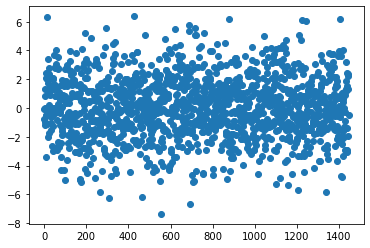

In [19]:
#first dimension of output is number of time steps
#second dimension of output is patient - ID's are in chronological order
#Last dimension is mean/covariance

dim = 8
modeloutput = np.load("mean_cov.npy")
times_pat = np.load("time.npy")
print(times_pat.shape)
print(modeloutput.shape)
i = 0
val = np.random.normal(modeloutput[:,0,i],np.sqrt(np.abs(modeloutput[:,0,i+8])))
plt.scatter(np.arange(modeloutput.shape[0]),val)

# Post processing of GRU-ODE output

In [12]:


patID = np.random.choice(np.arange(modeloutput.shape[1]),size=1)[0]
gtind = np.argwhere(inparr[:,0].squeeze() == patID)
gtimes = inparr[gtind,1]
print(gtimes)
print(times_pat)

np.argwhere(times_pat == gtimes.squeeze())




NameError: name 'modeloutput' is not defined

#  GRU-ODE Preprocessing (no dim-reduction)

In [9]:


#Standardize data w.r.t. time
"""
std_data = True
if std_data:
    
    # Split each patient into 5 time bins and get mean across all patients

    sbin = []
    thbin = []
    frbin = []
    fthbin = []
    sxbin = []
    nbins = 5


    for j in range(npat):

        #define time split for given patient
        tsplit = np.linspace(np.min(patimes[j]),np.max(patimes[j]),num=nbins)

        for i in range(len(patimes[j])):


            if patimes[j][i] >= tsplit[0] and patimes[j][i] < tsplit[1]: #second bin
                sbin.append(patensor[j][i])

            if patimes[j][i] >= tsplit[1] and patimes[j][i] < tsplit[2]: #third bin
                thbin.append(patensor[j][i])

            if patimes[j][i] >= tsplit[2] and patimes[j][i] < tsplit[3]: #fourth bin
                frbin.append(patensor[j][i])

            if patimes[j][i] >= tsplit[3] and patimes[j][i] < tsplit[4]: #fifth bin
                fthbin.append(patensor[j][i])

            if patimes[j][i] >= tsplit[4]: #fifth bin
                sxbin.append(patensor[j][i])



    sbin_avg = np.array(sbin).mean(axis=0)
    thbin_avg = np.array(thbin).mean(axis=0)
    frbin_avg = np.array(frbin).mean(axis=0)
    fthbin_avg = np.array(fthbin).mean(axis=0)
    sxbin_avg = np.array(sxbin).mean(axis=0)
    


    sbin_std = np.array(sbin).std(axis=0)
    thbin_std = np.array(thbin).std(axis=0)
    frbin_std = np.array(frbin).std(axis=0)
    fthbin_std = np.array(fthbin).std(axis=0)
    sxbin_std = np.array(sxbin).std(axis=0)


    

    #Create tensor of standardized data

    std_patensor = []
    for j in range(npat):

        #define time split for given patient
        tsplit = np.linspace(np.min(patimes[j]),np.max(patimes[j]),num=nbins)

        temp = np.zeros((len(patimes[j]),114))
        for i in range(len(patimes[j])):
            
            for k in range(114):

                if patimes[j][i] >= tsplit[0] and patimes[j][i] < tsplit[1]: #second bin
                    if sbin_avg[k] != 0:
                        temp[i,k] = (patensor[j][i,k] - sbin_avg[k])/sbin_std[k] 

                if patimes[j][i] >= tsplit[1] and patimes[j][i] < tsplit[2]: #third bin
                    if thbin_avg[k] !=0:
                        temp[i,k] = (patensor[j][i,k] - thbin_avg[k])/thbin_std[k] 

                if patimes[j][i] >= tsplit[2] and patimes[j][i] < tsplit[3]: #fourth bin
                    if frbin_avg[k] != 0:
                        temp[i,k] = (patensor[j][i,k] - frbin_avg[k])/frbin_std[k] 

                if patimes[j][i] >= tsplit[3] and patimes[j][i] < tsplit[4]: #fifth bin
                    if fthbin_avg[k] != 0:
                        temp[i,k] = (patensor[j][i,k] - fthbin_avg[k])/fthbin_std[k] 

                if patimes[j][i] >= tsplit[4]: #fifth bin
                    if sxbin_avg[k] != 0:
                        temp[i,k] = (patensor[j][i,k] - sxbin_avg[k])/sxbin_std[k] 

        std_patensor.append(temp)



    #Check to make sure the number of time points are consistent

    for i in range(npat):
        if patensor[i].shape[0] != std_patensor[i].shape[0] :
            print(i)"""

'\nstd_data = True\nif std_data:\n    \n    # Split each patient into 5 time bins and get mean across all patients\n\n    sbin = []\n    thbin = []\n    frbin = []\n    fthbin = []\n    sxbin = []\n    nbins = 5\n\n\n    for j in range(npat):\n\n        #define time split for given patient\n        tsplit = np.linspace(np.min(patimes[j]),np.max(patimes[j]),num=nbins)\n\n        for i in range(len(patimes[j])):\n\n\n            if patimes[j][i] >= tsplit[0] and patimes[j][i] < tsplit[1]: #second bin\n                sbin.append(patensor[j][i])\n\n            if patimes[j][i] >= tsplit[1] and patimes[j][i] < tsplit[2]: #third bin\n                thbin.append(patensor[j][i])\n\n            if patimes[j][i] >= tsplit[2] and patimes[j][i] < tsplit[3]: #fourth bin\n                frbin.append(patensor[j][i])\n\n            if patimes[j][i] >= tsplit[3] and patimes[j][i] < tsplit[4]: #fifth bin\n                fthbin.append(patensor[j][i])\n\n            if patimes[j][i] >= tsplit[4]: #fif

In [45]:
#Standardize data w.r.t. features

std_data = True

if std_data:

    meancyto = np.zeros(featuredim)
    stdcyto = np.zeros(featuredim)

    for k in range(featuredim):
        strfeat = []
        for i in range(npat):
            strfeat.append(patensor[i][:,k])

        strfeat = np.concatenate(strfeat)
        meancyto[k] = np.mean(strfeat)
        stdcyto[k] = np.std(strfeat)

    std_patensor = []
    for i in range(npat):
        
        temp = np.zeros((patensor[i].shape[0],featuredim))
        for k in range(featuredim):
            
            temp[:,k] = (patensor[i][:,k] - meancyto[k])/stdcyto[k]
            
        std_patensor.append(temp)
        



    #Check standardization
    check =[]
    for i in range(npat):
        for k in range(featuredim):
            check.append(std_patensor[i][:,k])

    check = np.concatenate(check)

    print(np.mean(check))
    print(np.std(check))


1.3449129635472908e-18
1.0


In [46]:
#Create column names for mask and feature values

maskcol = []
for i in range(mask[0].shape[1]):
    x = "Mask_" + str(i) 
    maskcol.append(x)
    
valcol = []
for i in range(mask[0].shape[1]):
    x = "Value_" + str(i)
    valcol.append(x)
    
columns =  ['ID' ,'Time'] + valcol + maskcol + ['Cov'] 

In [47]:
# Create for loop to concatenate all patient data in correct GRU-ODE input format

#mintimes = np.min(np.concatenate( patimes[:-1] , axis=0))
pre_list = []
ntime_pat = 5 #Minimum number of time points patient needs to have
for i in range(len(patensor) - 1): #Last patient has negative time point, leave off
    
    #if len(patimes[i]) >= ntime_pat:
    if std_data:
        values_pone = std_patensor[i].squeeze()
    else:
        values_pone = patensor[i].squeeze()
        
    mask_pone = mask[i].squeeze()
    time_pone = np.expand_dims(patimes[i],axis=1) 
    ID = np.full((patensor[i].shape[0],1),i)
    cov = np.zeros((patensor[i].shape[0],1))   
    #cov = 0.5
    pre_list.append(np.concatenate((ID,time_pone,values_pone,mask_pone,cov),axis=1))
    
    
preproc_arr = np.concatenate(pre_list,axis=0)
print(preproc_arr.shape)


(1423, 231)


In [48]:
# Save ground truth array
groundtruth_preprocess = np.save("processed_data/gt_processed.npy",preproc_arr)

In [49]:
# Create for loop to concatenate all patient data while holding out time point

k = -1 #time point to hold out
ntime_pat = 5 #Only include patients with at least 5 time points
pre_list_ltime = []
for i in range(len(patensor) - 1):
    
    if len(patimes[i]) >= ntime_pat:
    
        if std_data:
            values_pone = std_patensor[i][:k,:].squeeze()
        else: 
            values_pone = patensor[i][:k,:].squeeze()
        mask_pone = mask[i][:k,:].squeeze()
        time_pone = np.expand_dims(patimes[i],axis=1)[:k,:]
        ID = np.full((values_pone.shape[0],1),i)
        cov = np.zeros((values_pone.shape[0],1))         
        #cov = 0.5
        pre_list_ltime.append(np.concatenate((ID,time_pone,values_pone,mask_pone,cov),axis=1))
preproc_arrltime = np.concatenate(pre_list_ltime,axis=0)


In [50]:
#Define csv file of data to run

#Select data to feed to network
input_gruode = preproc_arrltime

#Definte dataframe
df = pd.DataFrame(input_gruode, columns = columns)
df.to_csv('processed_data/patrej_gt.csv',index=False)

In [51]:
print(np.max(np.concatenate( patimes[:-1] , axis=0)))

1260.0


In [52]:
#Creating metadata file

print("GRU-ODE input matrix",input_gruode.shape)
T = input_gruode[:,1].max()
delta_t = 2
N = input_gruode.shape[0]
metadata_dict = {"T":T,"delta_t":delta_t,"N":N}
print(metadata_dict)
np.save("processed_data/patrej_gt_metadata.npy",metadata_dict)



GRU-ODE input matrix (1120, 231)
{'T': 1250.0, 'delta_t': 2, 'N': 1120}


In [53]:
print(preproc_arrltime.shape)

(1120, 231)


# Run GRU-ODE-Bayes

In [95]:
%run -i '/home/of56/gru_ode_bayes/experiments/Cytokine/cytokine_gru_ode.py'

{'T': 1250.0, 'delta_t': 2, 'N': 1120}
1120
Length of Training ID's 784
Length of Validation ID: 336


0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.46s/it]

Epoch 0
Loss tensor(120420.6875, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 1
Loss tensor(119583.2031, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 2
Loss tensor(118902.7891, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 3
Loss tensor(118327.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 4
Loss tensor(117792.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 5
Loss tensor(117280.6250, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 6
Loss tensor(116812.7422, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 7
Loss tensor(116405.3984, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 8
Loss tensor(115939.7344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 9
Loss tensor(115528.2031, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 10
Loss tensor(115066.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.78s/it]

Epoch 11
Loss tensor(114682.0547, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 12
Loss tensor(114293.6797, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 13
Loss tensor(113828.0156, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 14
Loss tensor(113519.2578, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 15
Loss tensor(113118.4375, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.44s/it]

Epoch 16
Loss tensor(112842.5312, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 17
Loss tensor(112448.3125, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 18
Loss tensor(112160.3438, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 19
Loss tensor(111869.7500, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 20
Loss tensor(111540.2344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 21
Loss tensor(111258.7344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 22
Loss tensor(110902.2812, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 23
Loss tensor(110622.2344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.56s/it]

Epoch 24
Loss tensor(110471., device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 25
Loss tensor(110120.1719, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 26
Loss tensor(109863.2891, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 27
Loss tensor(109566.3594, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 28
Loss tensor(109260.7500, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 29
Loss tensor(109041.3906, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 30
Loss tensor(108680.8359, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 31
Loss tensor(108307.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 32
Loss tensor(108042.2734, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 33
Loss tensor(107828.0859, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 34
Loss tensor(107560.2031, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 35
Loss tensor(107191.5312, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.57s/it]

Epoch 36
Loss tensor(106934.4219, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 37
Loss tensor(106642.5625, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 38
Loss tensor(106257.3281, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 39
Loss tensor(105925.6953, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 40
Loss tensor(105625.3438, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 41
Loss tensor(105292.9297, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 42
Loss tensor(105049.6719, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 43
Loss tensor(104637.3281, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 44
Loss tensor(104401.1953, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 45
Loss tensor(104043.0234, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 46
Loss tensor(103661.6016, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 47
Loss tensor(103403.9219, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 48
Loss tensor(103078.1250, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 49
Loss tensor(102650.4844, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 50
Loss tensor(102382.3438, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.56s/it]

Epoch 51
Loss tensor(102060.5312, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 52
Loss tensor(101671.8828, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.43s/it]

Epoch 53
Loss tensor(101310.6250, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 54
Loss tensor(101187.4688, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 55
Loss tensor(100686.7031, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 56
Loss tensor(100534.9688, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 57
Loss tensor(100122.8281, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 58
Loss tensor(99952.3281, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 59
Loss tensor(99582.1719, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 60
Loss tensor(99139.3750, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 61
Loss tensor(98850.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 62
Loss tensor(98438.2109, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 63
Loss tensor(98272.9297, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.54s/it]

Epoch 64
Loss tensor(97823.4219, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 65
Loss tensor(97524.9688, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 66
Loss tensor(97417.2656, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 67
Loss tensor(97021.1016, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 68
Loss tensor(96588.2578, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 69
Loss tensor(96363.7656, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 70
Loss tensor(96080.7812, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 71
Loss tensor(95735.6719, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 72
Loss tensor(95536.8594, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.42s/it]

Epoch 73
Loss tensor(95249.0938, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 74
Loss tensor(94974.7344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 75
Loss tensor(94720.8281, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 76
Loss tensor(94151.3906, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.54s/it]

Epoch 77
Loss tensor(94058.9062, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 78
Loss tensor(93652.3125, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 79
Loss tensor(93419.3594, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 80
Loss tensor(92866.6875, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 81
Loss tensor(92643.8906, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.41s/it]

Epoch 82
Loss tensor(92574.8594, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 83
Loss tensor(92071.3906, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 84
Loss tensor(91650.6562, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 85
Loss tensor(91387.7969, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 86
Loss tensor(91136.6016, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 87
Loss tensor(90886.5469, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 88
Loss tensor(90468.5234, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 89
Loss tensor(90080.1562, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 90
Loss tensor(89894.5781, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 91
Loss tensor(89696.7344, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.57s/it]

Epoch 92
Loss tensor(89300.6641, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 93
Loss tensor(89003.4297, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 94
Loss tensor(88579.5859, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 95
Loss tensor(88225.4766, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.38s/it]

Epoch 96
Loss tensor(88075.9062, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 97
Loss tensor(87719.5625, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.40s/it]

Epoch 98
Loss tensor(87531.6406, device='cuda:0', grad_fn=<AddBackward0>)



0it [00:00, ?it/s]/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])
1it [00:02,  2.39s/it]

Epoch 99
Loss tensor(87394.5625, device='cuda:0', grad_fn=<AddBackward0>)



/gpfs/ysm/home/of56/gru_ode_bayes/gru_ode_bayes/data_utils.py:238: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/torch/csrc/utils/tensor_new.cpp:210.)
  df_cov    = torch.Tensor([b["cov"] for b in batch])


778
tensor(103)
torch.Size([906, 104, 228])
Done!


In [86]:

#Load output from GRU-ODE
mapID_train = np.load("mapID_train.npy").T # maps shuffled observation training ID's to ground truth
mapID_val = np.load("mapID_val.npy").T # maps shuffled observation validation ID's to ground truth

modtime = np.load("time.npy")
obs = np.load("obs_id.npy")
meanlogvar = np.load("mean_cov.npy")

print("Shape of output tensor",meanlogvar.shape)
print(obs.shape)
print(len(np.unique(obs)))


Shape of output tensor (906, 104, 228)
(778,)
104


In [54]:
#Extract mean and logvariance


m_npat = meanlogvar.shape[1]
mean = meanlogvar[:,:,:featuredim]
logvar = meanlogvar[:,:,featuredim:]

#Get correct patient from ground truth array
gtID = []
for i in range(m_npat):
    gtID.append(int(mapID_train[np.argwhere(mapID_train[:,0] == i).squeeze(),1][0]))

gtcomp = []
for j in range(m_npat):
    if std_data:
        gtcomp.append(std_patensor[gtID[j]]) 
    else:
        gtcomp.append(patensor[gtID[j]]) 

    
#Samples mean and variance and compresses model output
mean_only = True
alltimepts = False
compressmod_output = [] 
compressmod_output_mean = []
compressmod_output_std = []
compressmod_output_range = []
newtimeind = []

for j in range(m_npat):
    
    #Go through all time points for a given ground truth patient
    timeindex = []
    for i in range(patensor[gtID[j]].shape[0]): 
        timeindex.append(np.abs(modtime - patimes[gtID[j]][i]).argmin()) #Get ground truth time index closes to model 

    timeindex = np.array(timeindex) #array of time points for a given patient

    #Append matrix of sample values and time points 
    if not alltimepts:
        
        if mean_only:
            
            #Mean and standard deviation
            compressmod_output_mean.append(mean[timeindex,j,:])
            compressmod_output_std.append(np.sqrt(np.exp(logvar[timeindex,j,:])))
            
            #Get range of values
            bmr = mean[timeindex,j,:] - np.sqrt(np.exp(logvar[timeindex,j,:]))
            upr = mean[timeindex,j,:] + np.sqrt(np.exp(logvar[timeindex,j,:]))
            
            compressmod_output_range.append(np.array([bmr,upr]))
            newtimeind.append(modtime[timeindex])
            
        else:
            compressmod_output.append(np.random.normal(mean[timeindex,j,:],np.sqrt(np.exp(logvar[timeindex,j,:]))))
            newtimeind.append(modtime[timeindex])
            
    else:
        if mean_only:
  
            #Mean and standard deviation
            compressmod_output_mean.append(mean[:,j,:])
            compressmod_output_std.append(np.sqrt(np.exp(logvar[:,j,:])))
            
            #Get range of values
            bmr = mean[:,j,:] - np.sqrt(np.exp(logvar[:,j,:]))
            upr = mean[:,j,:] + np.sqrt(np.exp(logvar[:,j,:]))
            
            compressmod_output_range.append(np.array([bmr,upr]))
            newtimeind.append(modtime)

        else:
            compressmod_output.append(np.random.normal(mean[:,j,:],np.sqrt(np.exp(logvar[:,j,:]))))
            newtimeind.append(modtime)


# Use 'gtcomp' and 'compressmod_output' to plot/compare values

print(len(gtcomp))
print(len(compressmod_output_mean))

print(gtcomp[0].shape)
print(compressmod_output_mean[0].shape)

NameError: name 'meanlogvar' is not defined

# Analysis AND Plotting of point predictions method 1

In [88]:
# 1) Compute statistics based on metric [ a) average RPE b) percentage of ground truth stats in interval c) trend ]


def metric_comp(metric_type,thresh,nbstd,hdtime,featind):
    
    "Computes average relative percent error across patients for each cytookine or % of ground truth values within prediction interval"

    #RPE metric
    if metric_type == 'RPE':
        metric = np.zeros(featuredim)
        for k in featind:
            t = []
            for i in range(m_npat):
                t.append( ( (np.abs(gtcomp[i][hdtime,k] - compressmod_output_mean[i][hdtime,k]) ) /gtcomp[i][hdtime,k] ) * 100 )
            metric[k] = np.mean(t)


    #Prediction Interval metric
    if metric_type == 'pred_int':
        metric = np.zeros(len(featind))    
        correct = 0

        #Determine standard deviation range for each feature
        gt_range = np.zeros(len(featind))
        for k in featind:
            std_int = []
            for i in range(m_npat):
                std_int.append(gtcomp[i][:,k])
            std_int = np.concatenate(std_int)  
            gt_range[k] = (np.max(std_int) - np.min(std_int))

        #Compute metric
        check_x = []
        for k in featind:
            correct = 0
            x = 0
            for i in range(m_npat):

                if (compressmod_output_std[i][hdtime,k] * 2)/gt_range[k] < thresh: #Only compute metric if prediction interval is tight for given patient
                    x += 1

                    if gtcomp[i][hdtime,k] < compressmod_output_mean[i][hdtime,k] + (nbstd*compressmod_output_std[i][hdtime,k]):
                        if gtcomp[i][hdtime,k] > compressmod_output_mean[i][hdtime,k] - (nbstd*compressmod_output_std[i][hdtime,k]):
                            correct += 1

            if x > 0:
                metric[k] = correct/x
            check_x.append(x)
            
    
    if metric_type == 'slope':
        #Compute average slope of last 3 time points:
        metric = np.zeros(featuredim)
        for k in range(featuredim):
            correct = 0
            for i in range(m_npat):
                slopeone= (std_patensor[i][-1,k] - std_patensor[i][-2,k])/(newtimeind[i][-1] - newtimeind[i][-2])
                slopetwo = (std_patensor[i][-2,k] - std_patensor[i][-3,k])/(newtimeind[i][-2] - newtimeind[i][-3])
                slopegt = (slopeone + slopetwo)/2

                slopeone= (gtcomp[i][-1,k] - gtcomp[i][-2,k])/(newtimeind[i][-1] - newtimeind[i][-2])
                slopetwo = (gtcomp[i][-2,k] - gtcomp[i][-3,k])/(newtimeind[i][-2] - newtimeind[i][-3])
                slopepred = (slopeone + slopetwo)/2


                if slopegt >= 0:
                    if slopepred >= 0:
                        correct += 1

                if slopegt < 0:
                    if slopepred < 0:
                        correct += 1

            metric[k] = correct/m_npat

    
    return metric

Metric results (RPE): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Metric results (pred_int): [0.98795181 0.98837209 0.98979592 0.99       1.         1.
 1.         1.         1.         1.         1.        ]
Metric results (slope): [0.98795181 0.98837209 0.98979592 0.99       1.         1.
 1.         1.         1.         1.         1.        ]
[0.61538462 0.44230769 0.48076923 0.50961538 0.45192308 0.45192308
 0.46153846 0.58653846 0.42307692 0.47115385 0.46153846 0.48076923
 0.51923077 0.41346154 0.57692308 0.55769231 0.49038462 0.375
 0.64423077 0.67307692 0.67307692 0.625      0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.53846154 0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.52884615 0.50961538 0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5       

/tmp/ipykernel_2472/1208921637.py:57: RuntimeWarning: divide by zero encountered in double_scalars
  slopeone= (std_patensor[i][-1,k] - std_patensor[i][-2,k])/(newtimeind[i][-1] - newtimeind[i][-2])
/tmp/ipykernel_2472/1208921637.py:61: RuntimeWarning: divide by zero encountered in double_scalars
  slopeone= (gtcomp[i][-1,k] - gtcomp[i][-2,k])/(newtimeind[i][-1] - newtimeind[i][-2])
/tmp/ipykernel_2472/1208921637.py:58: RuntimeWarning: divide by zero encountered in double_scalars
  slopetwo = (std_patensor[i][-2,k] - std_patensor[i][-3,k])/(newtimeind[i][-2] - newtimeind[i][-3])
/tmp/ipykernel_2472/1208921637.py:62: RuntimeWarning: divide by zero encountered in double_scalars
  slopetwo = (gtcomp[i][-2,k] - gtcomp[i][-3,k])/(newtimeind[i][-2] - newtimeind[i][-3])
/tmp/ipykernel_2472/1208921637.py:63: RuntimeWarning: invalid value encountered in double_scalars
  slopepred = (slopeone + slopetwo)/2
/tmp/ipykernel_2472/1208921637.py:59: RuntimeWarning: invalid value encountered in double_

<Figure size 432x288 with 0 Axes>

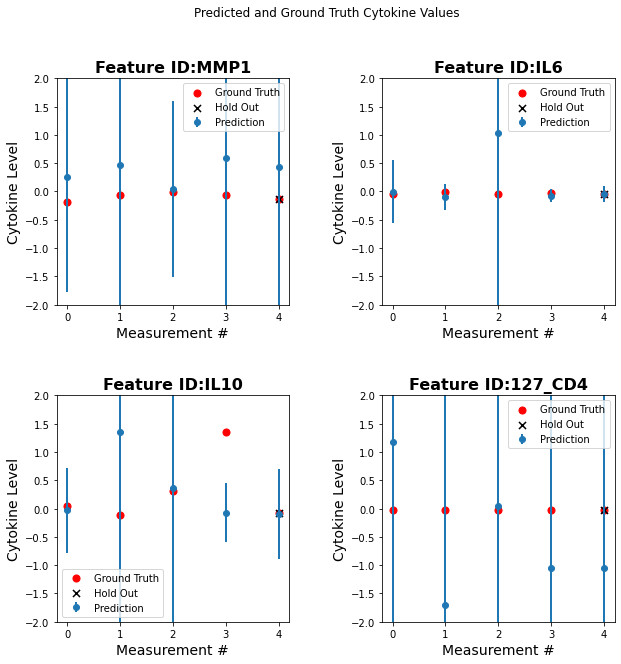

<Figure size 432x288 with 0 Axes>

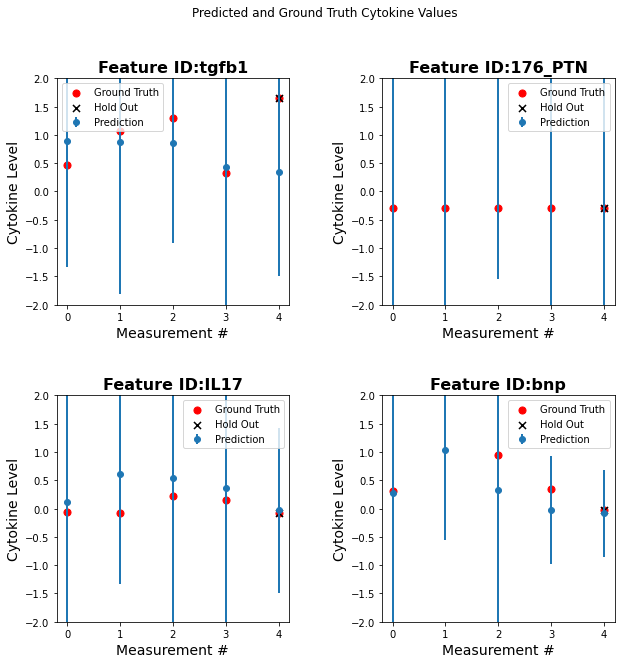

In [93]:
#Generate metric and plot


randID = np.random.choice(np.arange(1000000),size=1)[0]


# 1) Generate metric
metric_type = 'pred_int'
featind = np.arange(featuredim)
thresh=0.2
nbstd= 3
hdtime= -1
metric_o = metric_comp(metric_type,thresh,nbstd,hdtime,featind)


# 2) Select names and indices of top 10% of features
ntpft = int(0.10*featuredim)
if metric_type == 'pred_int':
    tpfeat= np.argsort(metric_o)[-ntpft:] # indices of top features
if metric_type == 'RPE':
    tpfeat = np.argsort(np.abs(metric_o))[:ntpft]
featurenames = cytokines.columns[2:][tpfeat].to_list()# Get names of features


# 3) Plot predictions
patID = np.random.randint(0,m_npat,size=1)[0] #select random patient
featID = np.random.choice(np.arange(ntpft),size=8,replace=False)


a = 1
j = 1
for i in featID:


    if a < 5:
        
        if a == 1:
            plt.figure()
            plt.subplots(nrows=2, ncols=2,figsize=(10,10))
            plt.suptitle("Predicted and Ground Truth Cytokine Values")
            plt.subplots_adjust(wspace=0.4, hspace=0.4)


        plt.subplot(2,2,a)
        plt.title("Feature ID:{}".format(featurenames[i]),fontsize=16,fontweight='bold')
        plt.xlabel("Measurement #",fontsize=14)
        plt.ylabel("Cytokine Level",fontsize=14)

        plt.errorbar(np.arange(gtcomp[patID].shape[0]),compressmod_output_mean[patID][:,tpfeat[i]],nbstd*compressmod_output_std[patID][:,tpfeat[i]],fmt='o',label='Prediction',elinewidth=2)
        plt.scatter(np.arange(gtcomp[patID].shape[0]),gtcomp[patID][:,tpfeat[i]],c='red',label='Ground Truth',s=50)
        plt.scatter(np.arange(gtcomp[patID].shape[0])[hdtime],gtcomp[patID][hdtime,tpfeat[i]],c='black',marker='x',label='Hold Out',s=50)
        plt.ylim(-2,2)
        plt.legend()
        if a == 4:
            plt.savefig("Results/Pred_" + str(patID) + "_" + str(1) + "_" + str(randID) + ".png")
        
    else: 
        
        if j == 1:
            plt.figure()
            plt.subplots(nrows=2, ncols=2,figsize=(10,10))
            plt.suptitle("Predicted and Ground Truth Cytokine Values ")
            plt.subplots_adjust(wspace=0.4, hspace=0.4)
        
        plt.subplot(2,2,j)
        plt.title("Feature ID:{}".format(featurenames[i]),fontsize=16,fontweight='bold')
        plt.xlabel("Measurement #",fontsize=14)
        plt.ylabel("Cytokine Level",fontsize=14)
        plt.errorbar(np.arange(gtcomp[patID].shape[0]),compressmod_output_mean[patID][:,tpfeat[i]],nbstd*compressmod_output_std[patID][:,tpfeat[i]],fmt='o',label='Prediction',elinewidth=2)
        plt.scatter(np.arange(gtcomp[patID].shape[0]),gtcomp[patID][:,tpfeat[i]],c='red',label='Ground Truth',s=50)
        plt.scatter(np.arange(gtcomp[patID].shape[0])[hdtime],gtcomp[patID][hdtime,tpfeat[i]],c='black',marker='x',label='Hold Out',s=50)
        plt.ylim(-2,2)
        plt.legend()

        j += 1
        
        if a == 8:
            plt.savefig("Results/Pred_" + str(patID) + "_" + str(2) + "_" + str(randID) +".png")

    a += 1


metric_type = 'RPE'
metric_o_rpe = metric_comp(metric_type,thresh,nbstd,hdtime,featind)
print("Metric results (RPE):",metric_o[np.argsort(np.abs(metric_o))][:ntpft])
    
metric_type = 'pred_int'
metric_o_pred_int = metric_comp(metric_type,thresh,nbstd,hdtime,featind)
print("Metric results (pred_int):",metric_o[np.argsort(metric_o)][-ntpft:])
    
metric_type = 'slope'
metric_o_slope = metric_comp(metric_type,thresh,nbstd,hdtime,featind)
print("Metric results (slope):",metric_o[np.argsort(metric_o)][-ntpft:])

print(metric_o_slope)
print(metric_o_rpe)
print(metric_o_pred_int)

    

In [94]:
    
# Save metrics/plots

nbr_epochs = 100
lr = 0.0001
now = datetime.datetime.now()
mout_dict = dict()
mout_dict["dt_time"] = str(now)
mout_dict["epochs"] = nbr_epochs
mout_dict["delta_t"] = delta_t
mout_dict["hidden_size"] = 100
mout_dict["p_hidden"] = 100
mout_dict["prep_hidden"] = 100
mout_dict["LR"] = lr
mout_dict["std_data"] = std_data
mout_dict["nbr_epochs"] = nbr_epochs
mout_dict["RPE"] = metric_o_rpe
mout_dict["pred_int"] = metric_o_pred_int
mout_dict["slope"] = metric_o_slope
mout_dict["ground_truth"] = gtcomp
mout_dict["nbstd"] = nbstd
mout_dict["thresh"] = thresh
mout_dict["hdtime"] = hdtime
mout_dict["predictions"] = compressmod_output
mout_dict["predictions_mean"] = compressmod_output_mean
mout_dict["predictions_std"] = compressmod_output_std
mout_dict["predictions_range"] = compressmod_output_range
mout_dict["mapID_train"] = mapID_train
mout_dict["mapID_val"] = mapID_val
mout_dict["modtime"] = modtime 
mout_dict["obs"] = obs
mout_dict["meanlogvar"] = meanlogvar 


with open('Results/experiment_'+ str(lr) + '_' + str(nbr_epochs) + '_'+ str(delta_t) +'_' +  str(randID) + '_' + str(thresh) + '_' + str(nbstd) + '.pkl',"wb") as f:
    pickle.dump(mout_dict,f)

    

In [105]:
#Load metrics

thresh = 0.2
lr = 0.001
nbr_epochs = 200
delta_t = 1
randID = 901300
nbstd = 2
ntpft = int(0.10*featuredim)


with open('Results/experiment_'+ str(lr) + '_' + str(nbr_epochs) + '_'+ str(delta_t) +'_' +  str(randID) + '_' + str(thresh) + '_' + str(nbstd) + '.pkl',"rb") as f:
    load_dict = pickle.load(f)
    

In [106]:
    
metric_o_rpe = load_dict["RPE"]
metric_o_pred_int = load_dict["pred_int"]
metric_o_slope = load_dict["slope"]

#RPE
print("Min RPE:",np.min(np.abs(metric_o_rpe[np.argsort(np.abs(metric_o_rpe))][:ntpft])))
print("Mean RPE:",np.mean(np.abs(metric_o_rpe[np.argsort(np.abs(metric_o_rpe))][:ntpft])))

#Prediction Interval
print("Max % prediction interval:",np.max(metric_o_pred_int[np.argsort(metric_o_pred_int)][-ntpft:]))
print("Mean % prediction interval:",np.mean(metric_o_pred_int[np.argsort(metric_o_pred_int)][-ntpft:]))

#Slope
print("Max %Slope:",np.max(metric_o_slope[np.argsort(metric_o_slope)][-ntpft:]))
print("Mean %Slope:",np.mean(metric_o_slope[np.argsort(metric_o_slope)][-ntpft:]))

tpfeat_slope = np.argsort(metric_o_slope)[-1]
tpfeat_pred_int = np.argsort(metric_o_pred_int)[-1]
tpfeat_RPE = np.argsort(np.abs(metric_o_rpe))[0]

print("Top RPE Feature: ",cytokines.columns[2:][tpfeat_RPE])
print("Top pred_interval Feature: ",cytokines.columns[2:][tpfeat_pred_int])
print("Top Slope Feature: ",cytokines.columns[2:][tpfeat_slope])


"""tpfeat_RPE = 
tpfeat_pred_int = 
tpfeat_slope = 
featurenames = cytokines.columns[2:][tpfeat].to_list()# Get names of features"""


Min RPE: 25.751040424147487
Mean RPE: 74.12308323879851
Max % prediction interval: 1.0
Mean % prediction interval: 0.9735683643705784
Max %Slope: 0.6730769230769231
Mean %Slope: 0.5944055944055945
Top RPE Feature:  VEGF_corelab
Top pred_interval Feature:  MMP1
Top Slope Feature:  TNF-RII


'tpfeat_RPE = \ntpfeat_pred_int = \ntpfeat_slope = \nfeaturenames = cytokines.columns[2:][tpfeat].to_list()# Get names of features'

# Analysis AND Plotting of point predictions method 2

Index of top features: [19, 20, 21, 16, 17, 12, 14, 0, 6, 8, 18]
(8, 11)
(8, 11)
Average percentage of correct predctions: 0.9283216783216782
[2 3 4 9 7 8 5 6]
2
3
4
9
7
8
5
6


/tmp/ipykernel_27540/358130239.py:9: RuntimeWarning: divide by zero encountered in true_divide
  x = (np.abs(gtcomp[j][h_tpt,:] - compressmod_output_mean[j][h_tpt,:])/gtcomp[j][h_tpt,:] ) * 100


<Figure size 432x288 with 0 Axes>

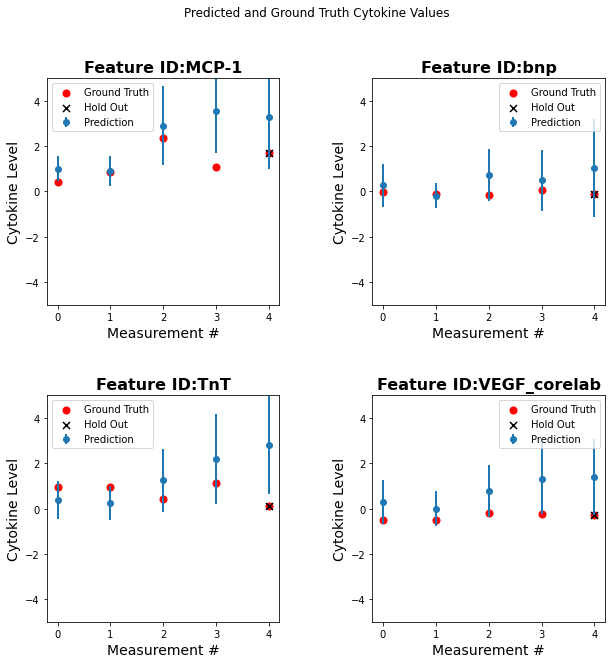

<Figure size 432x288 with 0 Axes>

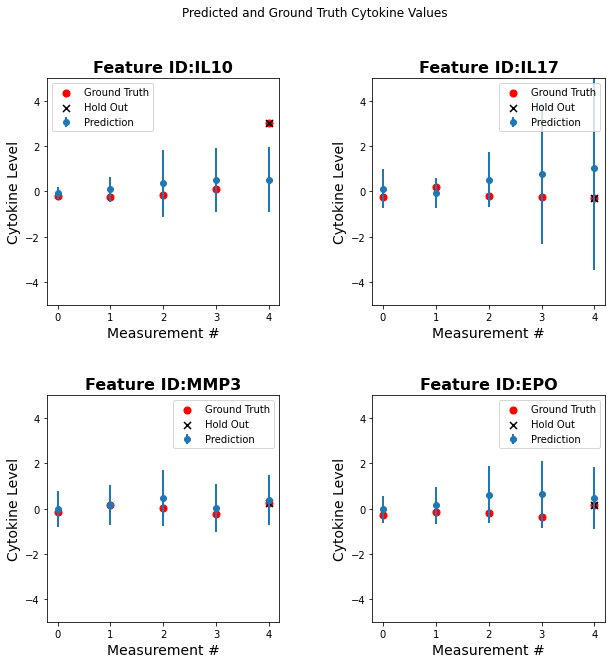

In [79]:
# 1) Get top 10% of performing features as measured by RPE

lwper = []
h_tpt = -1
n_tpft = int(featuredim*0.10)
tpfeat = []

for j in range(m_npat):
    x = (np.abs(gtcomp[j][h_tpt,:] - compressmod_output_mean[j][h_tpt,:])/gtcomp[j][h_tpt,:] ) * 100
    lwper.append(np.argsort(x)[:10].tolist())
lwper = [item for sublist in lwper for item in sublist]

from collections import Counter
counter = Counter(lwper)
top_n = counter.most_common(n_tpft)

for value,count in top_n:
    tpfeat.append(value)
    

print("Index of top features:",tpfeat)


# 2) Report percentage of patients whose ground truth falls within 1-3 std dev's of prediction 

print(compressmod_output_mean[0][:,tpfeat].shape)
print(compressmod_output_std[0][:,tpfeat].shape)

nbstd = 3
percorr_perfeat = np.zeros(n_tpft)

for k in range(n_tpft):
    correct = 0
    for j in range(m_npat):
        if gtcomp[j][h_tpt,tpfeat[k]] < (compressmod_output_mean[j][h_tpt,tpfeat[k]] + (nbstd*compressmod_output_std[j][h_tpt,tpfeat[k]])):
            if gtcomp[j][h_tpt,tpfeat[k]] > (compressmod_output_mean[j][h_tpt,tpfeat[k]] - (nbstd*compressmod_output_std[j][h_tpt,tpfeat[k]])): 
                correct += 1
                
    percorr_perfeat[k] = correct/m_npat   

print("Average percentage of correct predctions:",np.mean(percorr_perfeat))

# 3) Plot predictions

featurenames = cytokines.columns[2:][tpfeat].to_list()# Get names of features
patID = np.random.randint(0,m_npat,size=1)[0] #select random patient
featID = np.random.choice(np.arange(n_tpft),size=8,replace=False)
print(featID)

a = 1
j = 1
for i in featID:
    print(i)

    if a < 5:
        
        if a == 1:
            plt.figure()
            plt.subplots(nrows=2, ncols=2,figsize=(10,10))
            plt.suptitle("Predicted and Ground Truth Cytokine Values")
            plt.subplots_adjust(wspace=0.4, hspace=0.4)


        plt.subplot(2,2,a)
        plt.title("Feature ID:{}".format(featurenames[i]),fontsize=16,fontweight='bold')
        plt.xlabel("Measurement #",fontsize=14)
        plt.ylabel("Cytokine Level",fontsize=14)

        plt.errorbar(np.arange(gtcomp[patID].shape[0]),compressmod_output_mean[patID][:,tpfeat[i]],compressmod_output_std[patID][:,tpfeat[i]],fmt='o',label='Prediction',elinewidth=2)
        plt.scatter(np.arange(gtcomp[patID].shape[0]),gtcomp[patID][:,tpfeat[i]],c='red',label='Ground Truth',s=50)
        plt.scatter(np.arange(gtcomp[patID].shape[0])[-1],gtcomp[patID][-1,tpfeat[i]],c='black',marker='x',label='Hold Out',s=50)
        plt.ylim(-5,5)
        plt.legend()

        
    else: 
        
        if j == 1:
            plt.figure()
            plt.subplots(nrows=2, ncols=2,figsize=(10,10))
            plt.suptitle("Predicted and Ground Truth Cytokine Values ")
            plt.subplots_adjust(wspace=0.4, hspace=0.4)
        
        plt.subplot(2,2,j)
        plt.title("Feature ID:{}".format(featurenames[i]),fontsize=16,fontweight='bold')
        plt.xlabel("Measurement #",fontsize=14)
        plt.ylabel("Cytokine Level",fontsize=14)
        plt.errorbar(np.arange(gtcomp[patID].shape[0]),compressmod_output_mean[patID][:,tpfeat[i]],compressmod_output_std[patID][:,tpfeat[i]],fmt='o',label='Prediction',elinewidth=2)
        plt.scatter(np.arange(gtcomp[patID].shape[0]),gtcomp[patID][:,tpfeat[i]],c='red',label='Ground Truth',s=50)
        plt.scatter(np.arange(gtcomp[patID].shape[0])[-1],gtcomp[patID][-1,tpfeat[i]],c='black',marker='x',label='Hold Out',s=50)
        plt.ylim(-5,5)
        plt.legend()

        j += 1

    a += 1



In [ ]:
# Analysis of predictions (METHOD 2)

print(gtcomp[0].shape)
print(compressmod_output_mean[0].shape)
print(compressmod_output_range[0].shape)
print(compressmod_output_std[0].shape)



In [64]:
#Compute ground truth standard deviation range

hdtime = -1


#For each patients' prediction, store range
predrange = np.zeros((m_npat,featuredim))
for i in range(m_npat):
    for k in range(featuredim):
        predrange[i,k] = nbstd * compressmod_output_std[i][hdtime,k] * 2
        

#Get range of values for each feature acorss patients
gtrange = np.zeros(featuredim)
for k in range(featuredim):
    x = []
    for i in range(m_npat):
         x.append(gtcomp[i][hdtime,k])
            
    x = np.array(x)
    gtrange[k] = np.abs(np.max(x) - np.min(x))
    
    
#/np.abs(np.max(gtcomp[0][hdtime,k]) - np.min(gtcomp[0][hdtime,k]))

#print(gtcomp[0].shape)

print(gtrange)


[1.72903952e+00 6.35140661e-03 7.65490848e+00 5.57264165e-01
 2.53796375e-01 2.88750805e+00 9.27067370e+00 1.06774140e+00
 3.65013198e+00 4.44396770e+00 4.57919816e+00 4.40732078e+00
 9.10563938e+00 3.29481977e+00 7.02181896e+00 3.90029459e+00
 5.89909032e+00 9.40717981e+00 2.75310260e+00 4.20538591e+00
 4.18576924e+00 3.47781260e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.000000

In [60]:
hdtime = -1
nbstd = 1
metric_vec = np.zeros(featuredim)

for k in range(featuredim):
    correct = 0
    for i in range(m_npat):
        if gtcomp[i][hdtime,k] > ( compressmod_output_mean[i][hdtime,k] - (nbstd * compressmod_output_std[i][hdtime,k]) ):
            if gtcomp[i][hdtime,k] < ( compressmod_output_mean[i][hdtime,k] + (nbstd * compressmod_output_std[i][hdtime,k]) ):
                correct += 1

    metric_vec[k] = correct/m_npat
    
print(metric_vec)

(8, 114)
(8, 114)
(2, 8, 114)
(8, 114)
[0.95192308 0.96153846 0.93269231 0.99038462 0.96153846 0.89423077
 0.95192308 0.96153846 0.79807692 0.53846154 0.51923077 0.60576923
 0.59615385 0.85576923 0.69230769 0.92307692 0.83653846 0.48076923
 0.29807692 0.16346154 0.20192308 0.125      0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.125      0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.26923077 0.02884615 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.02884615 0.         0.         0.00961538 0.     

In [49]:
#Get numerical values



"""
#Quick check to make sure dimensions align
for i in range(meanlogvar.shape[1]):
    print("1{}".format(gtcomp[i].shape))
    print("2{}".format(compressmod_output[i].shape))
"""

timept = 0 # select time point to measure RPE for (held out time point)
if not mean_only:
    error_mat = np.zeros((m_npat,featuredim))
    for i in range(m_npat):
        for j in range(featuredim): #iterate
            error_mat[i,j] = np.abs((gtcomp[i][timept,j] - compressmod_output[i][timept,j])/np.abs(gtcomp[i][-1,j]))* 100

    print("Average relative percent error",np.mean(error_mat))
    
    
#Compute top 10% of feautres as measured by RPE

print(gtcomp[0].shape)
print(compressmod_output_mean[0].shape)

error_mat = np.zeros((m_npat,featuredim))
for i in range(m_npat):
    for j in range(featuredim):
        error_mat[i,j] = np.abs((gtcomp[i][timept,j]   -   compressmod_output_mean[i][timept,j])/np.abs(gtcomp[i][timept,j]))* 100

        
print(gtcomp)
sys.exit()
    
    

#Heat map of error
print(error_mat.shape)
plt.imshow(error_mat.T)
plt.colorbar()

#Average error across patients
plt.figure()
plt.scatter(np.arange(featuredim),error_mat.mean(axis=0))
plt.title("Relative Percent Error Across patients",fontsize=16)
plt.xlabel("Dimension",fontsize=14)
plt.ylabel("# Relative Percent Error",fontsize=14)




#Plot 4 random features for a given random patient to visualize predictions
patID = np.random.choice(np.arange(m_npat),size=1)[0]
featID = np.random.choice(np.arange(featuredim),size=4,replace=False)

plt.figure()

fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(10,10))
plt.suptitle("Cytokine predictions for random patient",fontsize=16,fontweight='bold')
axs[0,0].scatter(newtimeind[patID],gtcomp[patID][:,featID[0]],s=100)
axs[0,0].scatter(newtimeind[patID],compressmod_output[patID][:,featID[0]],s=100)
axs[0,0].set_title("Feature ID:{}".format(featID[0]))
axs[0,0].set_xlabel("Time")
axs[0,0].set_ylabel("Cytokine Level")
    

axs[0,1].scatter(newtimeind[patID],gtcomp[patID][:,featID[1]],s=100)
axs[0,1].scatter(newtimeind[patID],compressmod_output[patID][:,featID[1]],s=100)
axs[0,1].set_title("Feature ID:{}".format(featID[1]))
axs[0,1].set_xlabel("Time")
axs[0,1].set_ylabel("Cytokine Level")
    

axs[1,0].scatter(newtimeind[patID],gtcomp[patID][:,featID[2]],s=100)
axs[1,0].scatter(newtimeind[patID],compressmod_output[patID][:,featID[2]],s=100)
axs[1,0].set_title("Feature ID:{}".format(featID[2]))
axs[1,0].set_xlabel("Time")
axs[1,0].set_ylabel("Cytokine Level")
    

axs[1,1].scatter(newtimeind[patID],gtcomp[patID][:,featID[3]],s=100)
axs[1,1].scatter(newtimeind[patID],compressmod_output[patID][:,featID[3]],s=100)
axs[1,1].set_title("Feature ID:{}".format(featID[3]))
axs[1,1].set_xlabel("Time")
axs[1,1].set_ylabel("Cytokine Level")
    





(8, 114)
(8, 114)
[array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan

SystemExit: 

In [37]:
#Plotting
%matplotlib inline

#1st type of plotting:Random features, random patients, all time points

#Select random features/ID's
plotIDs = np.random.randint(0,mean.shape[1],size = 4)
featIDs = np.random.randint(0,mean.shape[2],size = 4)

print(compressmod_output[j].shape)

sys.exit()
fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(14,14))
for j in range(len(featIDs)):
    
    axs[0,0].scatter(newtimeind[plotIDs[j]],compressmod_output[plotIDs[j]][:,featIDs[0]])
    axs[0,0].scatter(newtimeind[plotIDs[j]],gtcomp[plotIDs[j]][:,featIDs[0]])
    axs[0,0].set_title("Feature ID:{}".format(featIDs[0]))
    axs[0,0].set_xlabel("Time")
    axs[0,0].set_ylabel("Cytokine Level")
    
    axs[0,1].scatter(newtimeind[plotIDs[j]],compressmod_output[plotIDs[j]][:,featIDs[1]])
    axs[0,1].set_title("Feature ID:{}".format(featIDs[1]))
    axs[0,1].set_xlabel("Time")
    axs[0,1].set_ylabel("Cytokine Level")
    
    axs[1,0].scatter(newtimeind[plotIDs[j]],compressmod_output[plotIDs[j]][:,featIDs[2]])
    axs[1,0].set_title("Feature ID:{}".format(featIDs[2]))
    axs[1,0].set_xlabel("Time")
    axs[1,0].set_ylabel("Cytokine Level")
    
    axs[1,1].scatter(newtimeind[plotIDs[j]],compressmod_output[plotIDs[j]][:,featIDs[3]])
    axs[1,1].set_title("FEature ID:{}".format(featIDs[3]))
    axs[1,1].set_xlabel("Time")
    axs[1,1].set_ylabel("Cytokine Level")


#Second type of plotting: temporal-PHATE





(5, 114)


SystemExit: 

# Getting Statistics

Average # of dimensions 30.350794511966107
Average # of time points 7.425742574257426


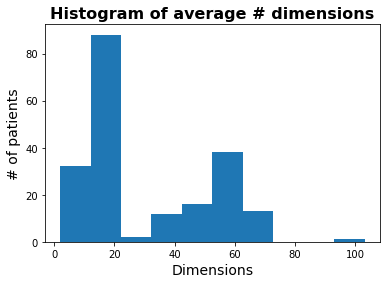

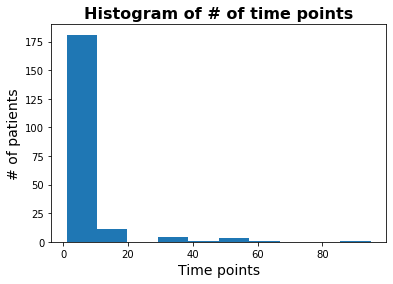

In [22]:
#patimes = stores patient times
#truedims = stores true dimensions
#metadata = stores date and patient ID


#Extract average number of dimensions for each time point

                 

plt.figure()
plt.title("Histogram of average # dimensions", fontsize=16,fontweight='bold')
#plt.plot(avdims)
plt.hist(avdims)
plt.xlabel("Dimensions",fontsize=14)
plt.ylabel("# of patients",fontsize=14)
plt.savefig("figures/Number_dimensions.png")

plt.figure()
plt.title("Histogram of # of time points",  fontsize=16, fontweight='bold')
#plt.plot(avtmpts)
plt.hist(avtmpts)
plt.ylabel("# of patients",fontsize=14)
plt.xlabel("Time points",fontsize=14)
plt.savefig("figures/Number_timepoints.png")

print("Average # of dimensions",np.mean(avdims))
print("Average # of time points",np.mean(avtmpts))

In [74]:
#Testing input for model

#print(mask[0])
#print(patensor[0])
print(len(patimes))
print(patimes[0])
print(patensor[0].shape)

202
[  0.   1.  21.  26.  28.  49. 109. 110.]
(8, 114)


/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:104: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:104: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:104: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:104: UserWarning: Cannot set knn (2) to be greater than n_samples - 2 (1). Setting knn=1
  warnings.warn(
/gpfs/ysm/project/krishnaswamy_smita/of56/conda_envs/fashenv/lib/python3.10/site-packages/graphtools/graphs.py:104: UserWarning: Can

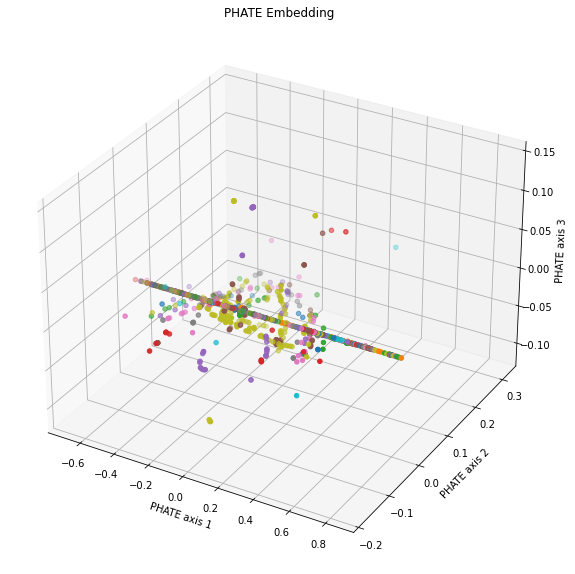

In [97]:
#Visualization with PHATE

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.title("PHATE Embedding")
ax.set_xlabel("PHATE axis 1")
ax.set_ylabel("PHATE axis 2")
ax.set_zlabel("PHATE axis 3")
for i in range(len(patensor)):
    X = patensor[i]
    phate_operator = phate.PHATE(random_state=42, verbose=False, n_components=3, knn=2)
    phate_emb = phate_operator.fit_transform(X)
    ax.scatter(phate_emb[:,0],phate_emb[:,1],phate_emb[:,2])


(60, 3)
(60, 114)


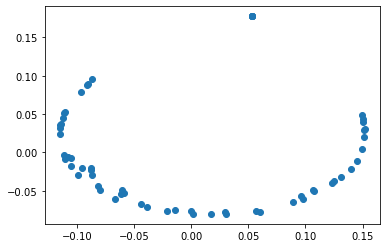

In [101]:
print(phate_emb.shape)
print(patensor[-1].shape)

plt.scatter(phate_emb[:,0],phate_emb[:,1])

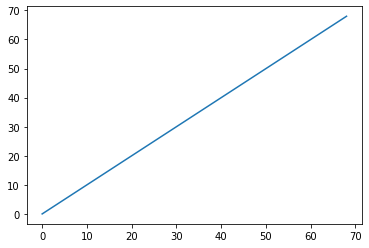

In [10]:
plt.plot(np.arange(69))

# Analyze Output from GRU-ODE

In [2]:

obs_ID = np.load("/home/of56/gru_ode_bayes/experiments/double_OU/obs_id.npy")
modeloutput = np.load("/home/of56/gru_ode_bayes/experiments/double_OU/mean_cov.npy")
groundtruth = np.load("/home/of56/gru_ode_bayes/experiments/double_OU/patrej_gtarr.npy")


In [4]:
print(obs_ID.shape)
print(modeloutput.shape)

(37,)
(634, 33, 228)


In [6]:
print(modeloutput[0,0,-10:])

[-4.752984  -4.6396646 -3.3736193 -4.8750954 -4.0040455 -4.7782607
 -4.044203  -3.9345086 -3.1275556 -4.4770103]


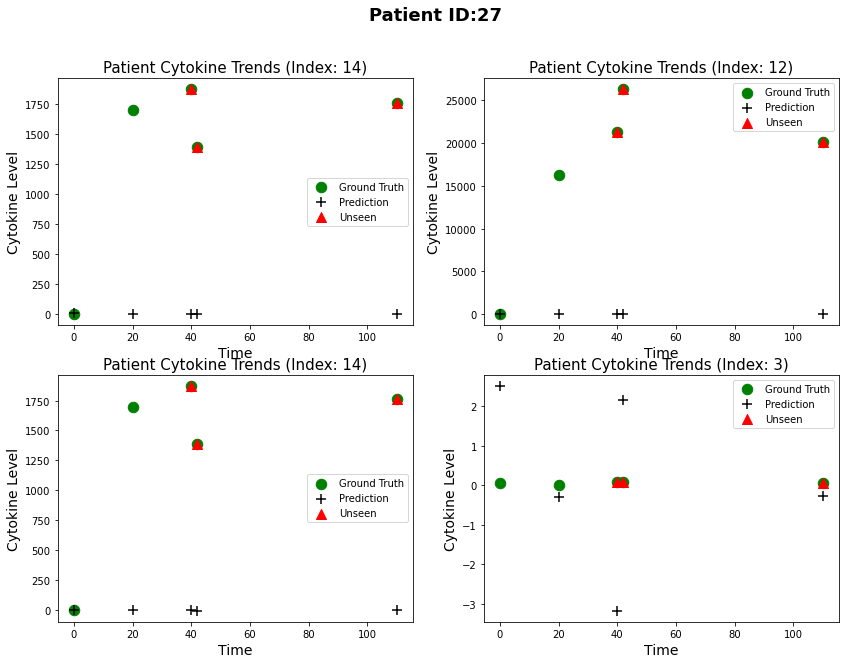

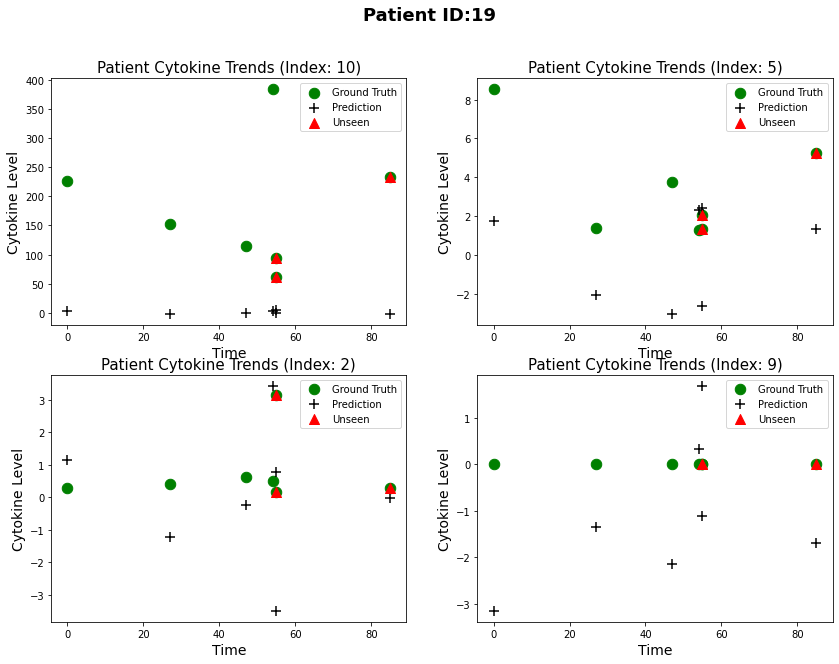

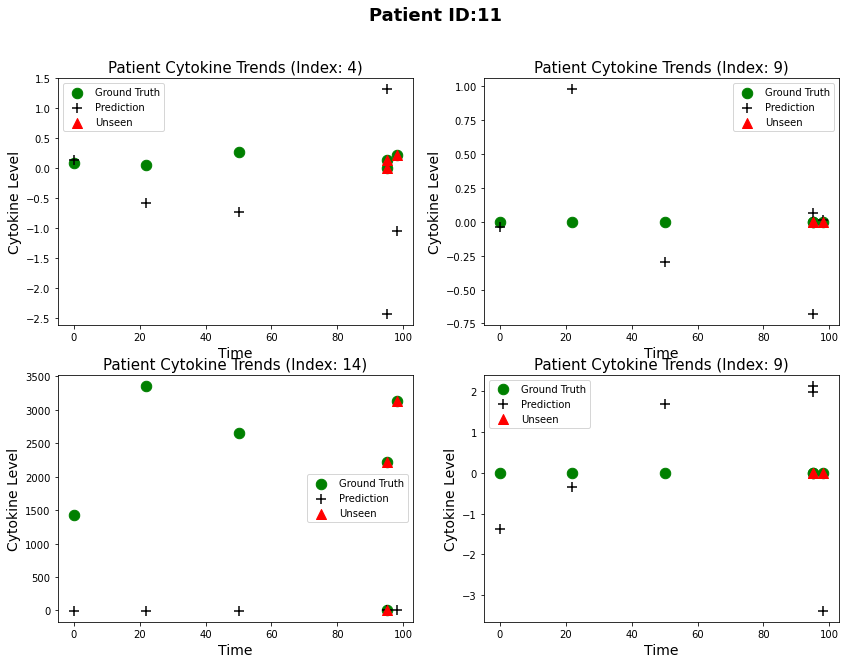

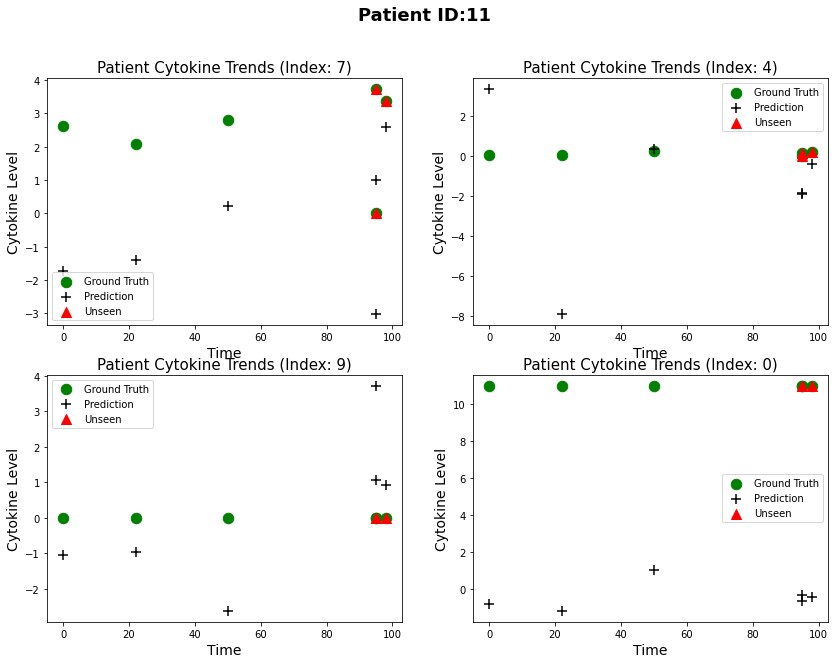

In [71]:
#Post processing

dim = 114
n_obs = 186
gtind = groundtruth[:,0].squeeze() #vector of patient ID's


for j in range(4):
    modID = np.random.choice(obs_ID,size=1)[0] #Selecting patient for analysis
    plt.figure(figsize=(14,10))
    for i in range(4):

        feature = np.random.choice(np.arange(15),size=1)[0]#Random selection of features
       
        gtobs = groundtruth[np.argwhere(gtind == modID),feature] #Gets ground truth observations at all times for given patient
        gtimepts = np.array(groundtruth[np.argwhere(gtind == modID),1].squeeze(),dtype=int) # Gets ground truth time points

        modmean = modeloutput[gtimepts,modID,feature] #Gets mean from model
        modcov = modeloutput[gtimepts,modID,feature + dim] #Gets variance
        sampfeat = np.random.normal(modmean,np.sqrt(np.abs(modcov))) #Get sample

        plt.subplot(2,2,i+1)
        plt.suptitle("Patient ID:" + str(modID),fontweight='bold',fontsize=18)
        plt.title("Patient Cytokine Trends (Index: " + str(feature) + ")",fontsize=15)
        plt.scatter(gtimepts,gtobs,s=110,c='green')
        plt.scatter(gtimepts,sampfeat,s=110,c='black',marker='+')
        plt.scatter(gtimepts[-3:],gtobs[-3:],marker='^',s=100,c='red')
        plt.xlabel("Time",fontsize=14)
        plt.ylabel("Cytokine Level",fontsize=14)
        plt.legend(["Ground Truth","Prediction","Unseen"])



[[8.48]
 [0.  ]
 [7.19]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]
 [0.  ]]


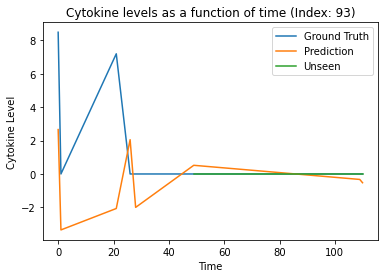

In [39]:

"""
plt.figure()
plt.suplot(2,2,1)
plt.plot(gtobs)
plt.plot(sampfeat)

plt.suplot(2,2,2)
plt.plot(gtobs)
plt.plot(sampfeat)

plt.suplot(2,2,3)
plt.plot(gtobs)
plt.plot(sampfeat)

plt.suplot(2,2,4)
"""


plt.title("Cytokine levels as a function of time (Index: " + str(feature) + ")")
plt.plot(gtimepts,gtobs)
plt.plot(gtimepts,sampfeat)
plt.plot(gtimepts[-3:],gtobs[-3:])
plt.xlabel("Time")
plt.ylabel("Cytokine Level")
plt.legend(["Ground Truth","Prediction","Unseen"])

print(gtobs)